In [1]:
from dataclasses import dataclass

import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from tqdm import tqdm

from uot import UOT, EntRegUOT
from uot import exact_uot, exact_entreg_uot
from uot import calc_B, calc_f
from sinkhorn import calc_U, sinkhorn_entreg_uot

np.random.seed(3698)

## Experiments

### Synthetic data

#### Configuration

In [2]:
# Dimension
n = 10

# Regularization
tau = 5.0

# Mass normalization
alpha = 2.0
beta = 4.0

# Number of eps
neps = 20

#### Generation

In [3]:
np.random.seed(3698)

# Cost matrix
C = np.random.uniform(low=1.0, high=50.0, size=(n, n))
C = (C + C.T) / 2.0

# Marginal vectors
a = np.random.uniform(0.1, 1.0, size=n)
b = np.random.uniform(0.1, 1.0, size=n)

a = a / a.sum() * alpha
b = b / b.sum() * beta

#### Scenarios

##### Different accuracy epsilon

In [4]:
# Original UOT problem
uot_p = UOT(C, a, b, tau)

# Optimal solution
f_optimal, X_optimal = exact_uot(uot_p)

print('Optimal:', f_optimal)

Optimal: 20.90467378709561


In [5]:
# Epsilons
eps_arr = np.linspace(start=1.0, stop=0.05, num=neps)

kfs, kcs = np.zeros((2, neps))

for i, eps in enumerate(eps_arr):
    # Entropic regularization parameter
    U = calc_U(uot_p, eps)
    eta = eps / U

    # Convert to Entropic Regularized UOT
    p = EntRegUOT(C, a, b, tau, eta)
    # g_best, u_opt, v_opt = exact_entreg_uot(p)

    # Sinkhorn
    _, log = sinkhorn_entreg_uot(p, eps)

    # Find kf
    kf = log['k_stop']

    # Find kc
    f_approx = np.array([
        calc_f(p, calc_B(p, u, v))
        for u, v in zip(log['u'], log['v'])
    ])
    kc = np.where(f_approx - f_optimal > eps)[0][-1]

    kfs[i] = kf
    kcs[i] = kc + 2

(1.05, -0.05)

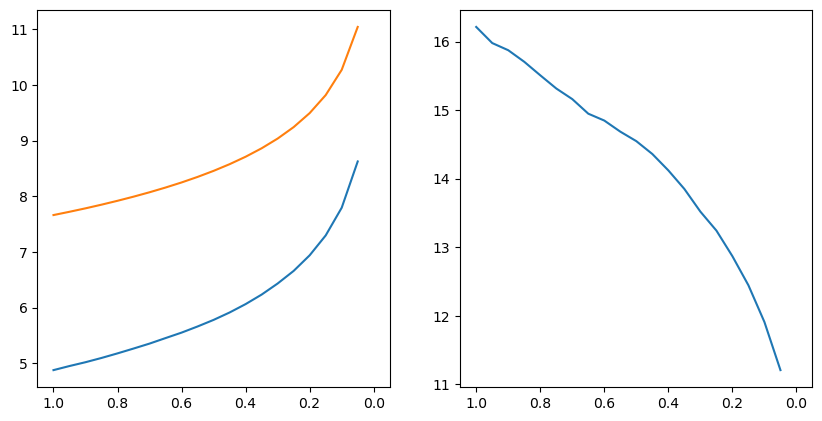

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100)

ax[0].plot(eps_arr, np.log(kcs), label='\log k_f')
ax[0].plot(eps_arr, np.log(kfs), label='\log k_c')
ax[0].set_xlim(1.0 + 0.05, 0 - 0.05)

ax[1].plot(eps_arr, kfs / kcs, label='\log k_f')
ax[1].set_xlim(1.0 + 0.05, 0 - 0.05)

##### Code